In this notebook, we will walk through the process of fine-tuning a semantic segmentation model on a custom dataset. The model we’ll be using is the pretrained Segformer, a powerful and flexible transformer-based architecture for segmentation tasks.

For our dataset, we’ll use segments/sidewalk-semantic, which contains labeled images of sidewalks, making it ideal for applications in urban environments.

Example use-case: This model could be deployed in a delivery robot that autonomously navigates sidewalks to deliver pizza right to your door 🍕

Once we’ve fine-tuned the model, we’ll demonstrate how to deploy it using the Serverless Inference API, making it accessible via a simple API endpoint.



In [1]:
!pip install -q datasets transformers evaluate wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00


In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
from datasets import load_dataset

sidewalk_dataset_identifier = "segments/sidewalk-semantic"
dataset = load_dataset(sidewalk_dataset_identifier)

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/324M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [4]:
dataset = dataset.shuffle(seed=42)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [5]:
image = train_ds[0]
image

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

In [6]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(repo_id=sidewalk_dataset_identifier, filename=filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

Id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [7]:
# color palette
sidewalk_palette = [
    [0, 0, 0],  # unlabeled
    [216, 82, 24],  # flat-road
    [255, 255, 0],  # flat-sidewalk
    [125, 46, 141],  # flat-crosswalk
    [118, 171, 47],  # flat-cyclinglane
    [161, 19, 46],  # flat-parkingdriveway
    [255, 0, 0],  # flat-railtrack
    [0, 128, 128],  # flat-curb
    [190, 190, 0],  # human-person
    [0, 255, 0],  # human-rider
    [0, 0, 255],  # vehicle-car
    [170, 0, 255],  # vehicle-truck
    [84, 84, 0],  # vehicle-bus
    [84, 170, 0],  # vehicle-tramtrain
    [84, 255, 0],  # vehicle-motorcycle
    [170, 84, 0],  # vehicle-bicycle
    [170, 170, 0],  # vehicle-caravan
    [170, 255, 0],  # vehicle-cartrailer
    [255, 84, 0],  # construction-building
    [255, 170, 0],  # construction-door
    [255, 255, 0],  # construction-wall
    [33, 138, 200],  # construction-fenceguardrail
    [0, 170, 127],  # construction-bridge
    [0, 255, 127],  # construction-tunnel
    [84, 0, 127],  # construction-stairs
    [84, 84, 127],  # object-pole
    [84, 170, 127],  # object-trafficsign
    [84, 255, 127],  # object-trafficlight
    [170, 0, 127],  # nature-vegetation
    [170, 84, 127],  # nature-terrain
    [170, 170, 127],  # sky
    [170, 255, 127],  # void-ground
    [255, 0, 127],  # void-dynamic
    [255, 84, 127],  # void-static
    [255, 170, 127],  # void-unclear
]

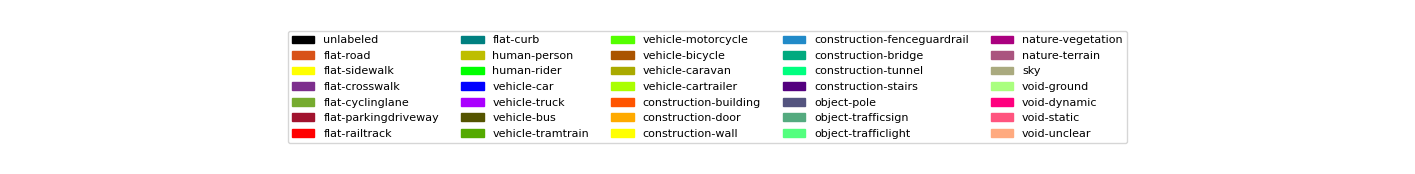

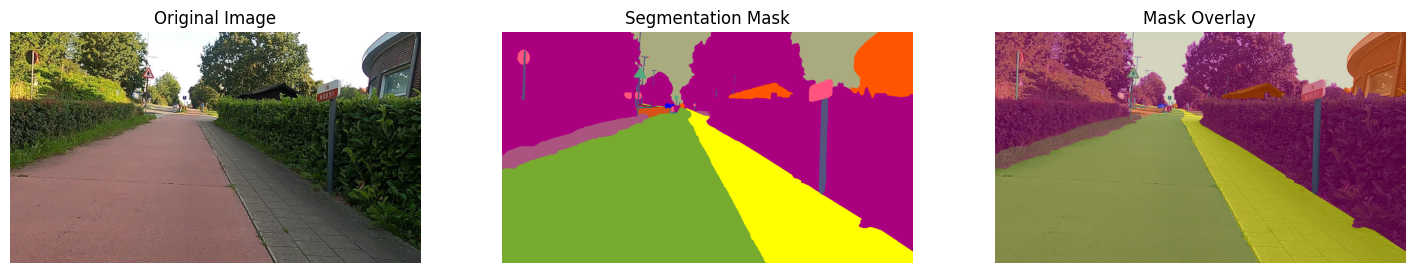

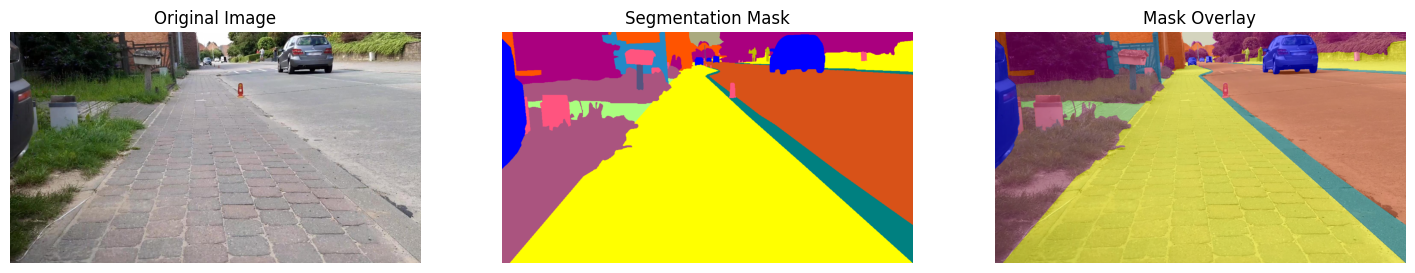

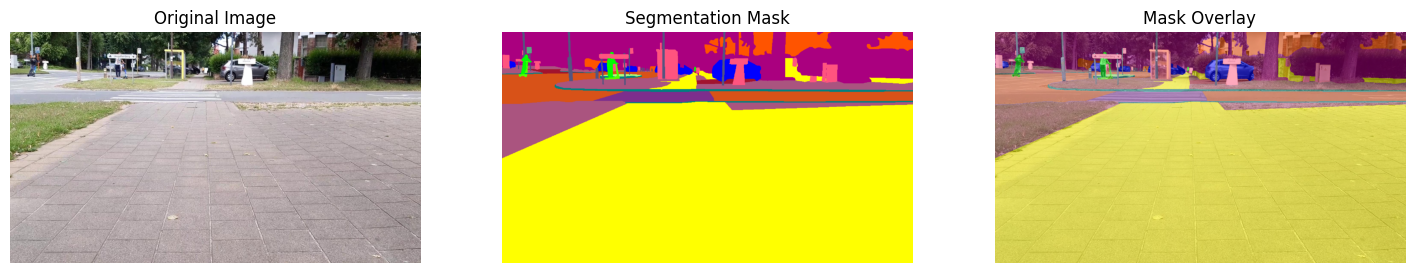

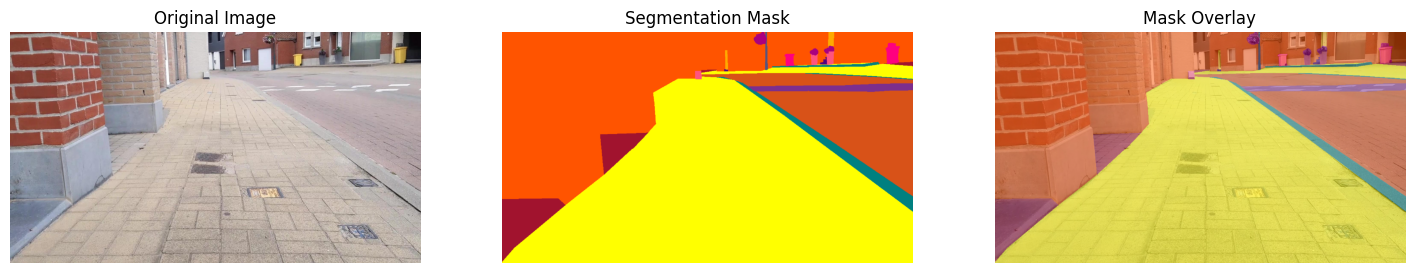

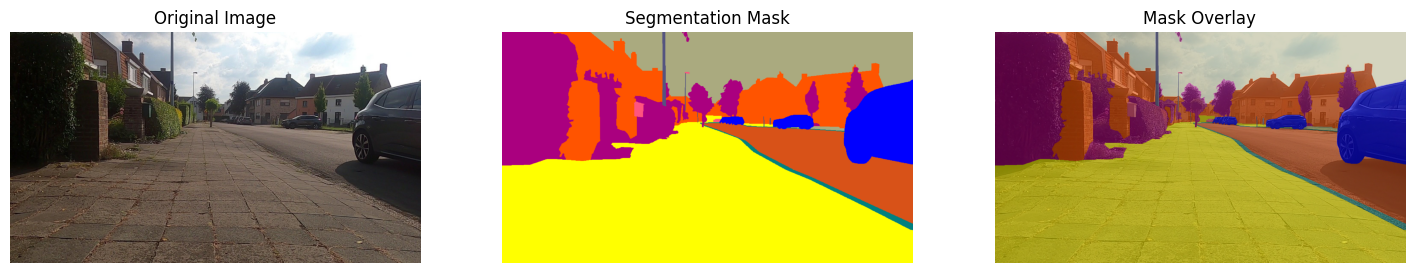

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [
    patches.Patch(color=np.array(color) / 255, label=label)
    for label, color in zip(id2label.values(), sidewalk_palette)
]

ax.legend(handles=legend_patches, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=5, fontsize=8)
ax.axis("off")
plt.show()

for i in range(5):
    image = train_ds[i]
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    # original image
    ax[0].imshow(image["pixel_values"])
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    mask_np = np.array(image["label"])

    # new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # assign colors to each value in mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, "RGB")

    # show segmentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title("Segmentation Mask")
    ax[1].axis("off")

    image_rgba = image["pixel_values"].convert("RGBA")
    colored_mask_rgba = colored_mask_img.convert("RGBA")

    # addjust transparency mask
    alpha = 128  # transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new("RGBA", colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    ax[2].imshow(superposed)
    ax[2].set_title("Mask Overlay")
    ax[2].axis("off")

    plt.show()

class occurences

In [9]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example["label"])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

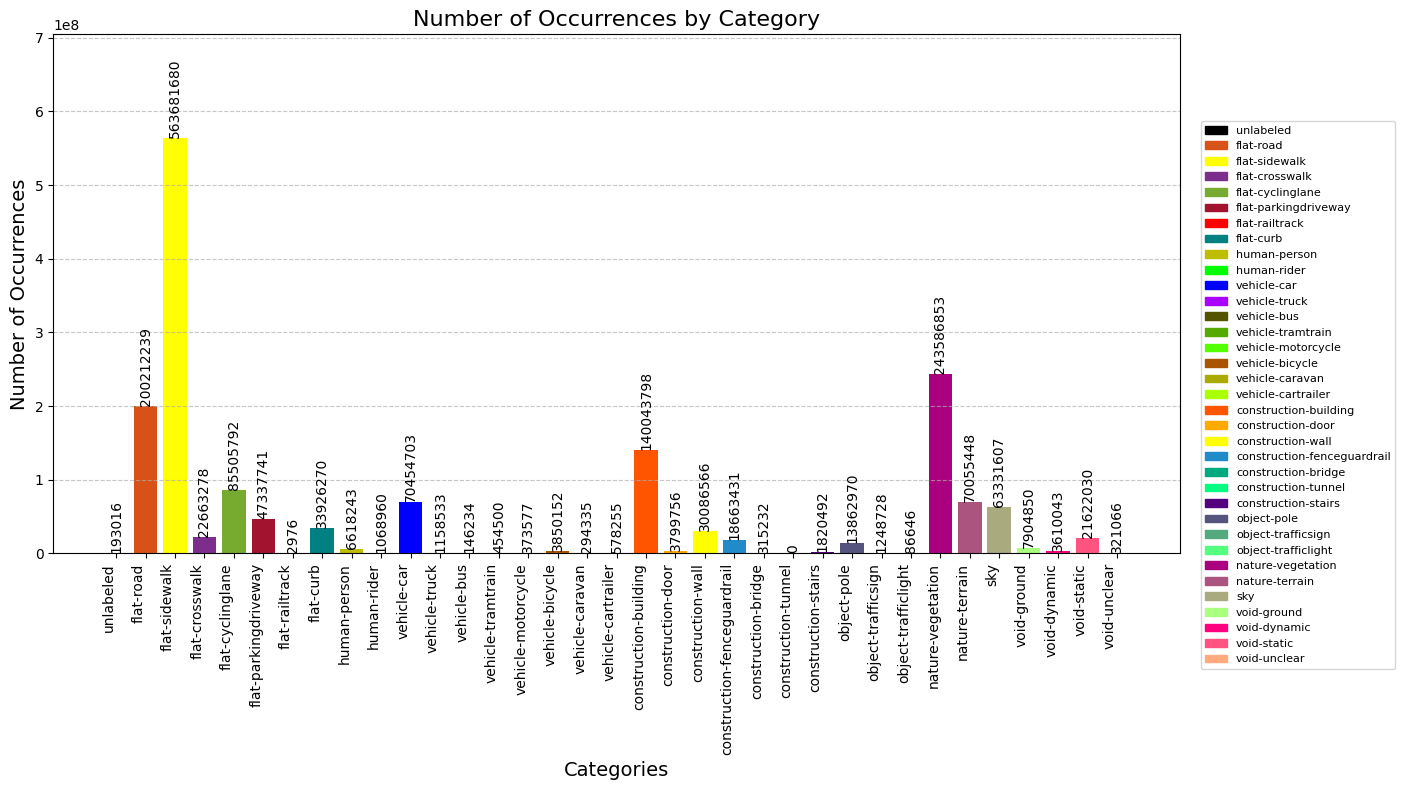

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import patches

labels = list(id2label.values())

# normalize colors in range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(range(len(labels)), class_counts, color=[normalized_palette[i] for i in range(len(labels))])

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha="right")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

# fix y-axis limit
y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + offset,
        f"{height}",
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=10,
        color="black",
    )

fig.legend(
    handles=legend_patches, loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8
)  # Adjust ncol as needed

plt.tight_layout()
plt.show()

init image processor

In [11]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

albumentations_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
        A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.4),
    ]
)

def train_transforms(example_batch):
    augmented_images = [albumentations_transform(image=np.array(x))["image"] for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(augmented_images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [12]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments
import wandb

output_dir = "./output"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=6e-5,
    num_train_epochs=10, # originally 20
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="wandb",
)

wandb.init(
    project="segformer-sidewalk-finetuned",
    name="segformer-sidewalk-finetuned",
    config=training_args,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Custom compute_metrics Method for Enhanced Logging with evaluate

In [14]:
import evaluate

evaluate.logging.set_verbosity_error()

In [15]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        # using _compute instead of compute: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        pred_labels = logits_tensor.detach().cpu().numpy()
        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels,
            )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Unlabeled,Accuracy Flat-road,Accuracy Flat-sidewalk,Accuracy Flat-crosswalk,Accuracy Flat-cyclinglane,Accuracy Flat-parkingdriveway,Accuracy Flat-railtrack,Accuracy Flat-curb,Accuracy Human-person,Accuracy Human-rider,Accuracy Vehicle-car,Accuracy Vehicle-truck,Accuracy Vehicle-bus,Accuracy Vehicle-tramtrain,Accuracy Vehicle-motorcycle,Accuracy Vehicle-bicycle,Accuracy Vehicle-caravan,Accuracy Vehicle-cartrailer,Accuracy Construction-building,Accuracy Construction-door,Accuracy Construction-wall,Accuracy Construction-fenceguardrail,Accuracy Construction-bridge,Accuracy Construction-tunnel,Accuracy Construction-stairs,Accuracy Object-pole,Accuracy Object-trafficsign,Accuracy Object-trafficlight,Accuracy Nature-vegetation,Accuracy Nature-terrain,Accuracy Sky,Accuracy Void-ground,Accuracy Void-dynamic,Accuracy Void-static,Accuracy Void-unclear,Iou Unlabeled,Iou Flat-road,Iou Flat-sidewalk,Iou Flat-crosswalk,Iou Flat-cyclinglane,Iou Flat-parkingdriveway,Iou Flat-railtrack,Iou Flat-curb,Iou Human-person,Iou Human-rider,Iou Vehicle-car,Iou Vehicle-truck,Iou Vehicle-bus,Iou Vehicle-tramtrain,Iou Vehicle-motorcycle,Iou Vehicle-bicycle,Iou Vehicle-caravan,Iou Vehicle-cartrailer,Iou Construction-building,Iou Construction-door,Iou Construction-wall,Iou Construction-fenceguardrail,Iou Construction-bridge,Iou Construction-tunnel,Iou Construction-stairs,Iou Object-pole,Iou Object-trafficsign,Iou Object-trafficlight,Iou Nature-vegetation,Iou Nature-terrain,Iou Sky,Iou Void-ground,Iou Void-dynamic,Iou Void-static,Iou Void-unclear
20,3.000200,3.003871,0.065374,0.108400,0.552978,nan,0.466849,0.914353,0.000000,0.000109,0.000009,nan,0.000150,0.000270,0.000000,0.026524,0.000000,0.000000,0.000000,0.000000,0.008934,0.000000,0.000000,0.812009,0.000000,0.000000,0.000042,0.000000,0.000000,0.000000,0.000473,0.000000,0.000000,0.622035,0.485416,0.238303,0.001484,0.000000,0.000236,0.000000,0.000000,0.268810,0.645546,0.000000,0.000107,0.000009,0.000000,0.000147,0.000269,0.000000,0.026109,0.000000,0.000000,0.000000,0.000000,0.005224,0.000000,0.000000,0.317118,0.000000,0.000000,0.000042,0.000000,0.000000,0.000000,0.000459,0.000000,0.000000,0.541801,0.245159,0.235620,0.001423,0.000000,0.000236,0.000000
40,2.844200,2.339696,0.083142,0.126161,0.592330,nan,0.625171,0.888314,0.000000,0.016852,0.000000,nan,0.000004,0.000000,0.000000,0.001184,0.000000,0.000000,0.000000,0.000000,0.000106,0.000000,0.000000,0.830870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.769103,0.464825,0.566852,0.000000,0.000000,0.000000,0.000000,nan,0.322531,0.669032,0.000000,0.016764,0.000000,0.000000,0.000004,0.000000,0.000000,0.001181,0.000000,0.000000,0.000000,0.000000,0.000104,0.000000,0.000000,0.345221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.638919,0.288479,0.544561,0.000000,0.000000,0.000000,0.000000
60,2.548300,2.098087,0.088281,0.131468,0.595522,nan,0.529953,0.903428,0.000000,0.007764,0.000000,nan,0.000000,0.000000,0.000000,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.838024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.742980,0.683284,0.630306,0.000000,0.000000,0.000000,0.000000,nan,0.287655,0.661767,0.000000,0.007764,0.000000,nan,0.000000,0.000000,0.000000,0.002700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.368249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.627969,0.366355,0.590826,0.000000,0.000000,0.000000,0.000000
80,2.629000,1.947438,0.095524,0.138857,0.613128,nan,0.700219,0.893633,0.000000,0.054907,0.000000,nan,0.000000,0.000000,0.000000,0.014909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.871531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.717109,0.633769,0.696208,0.000000,0.000000,0.000000,0.000000,nan,0.340304,0.699992,0.000000,0.0

TrainOutput(global_step=1000, training_loss=1.7311397997140885, metrics={'train_runtime': 3048.7648, 'train_samples_per_second': 2.624, 'train_steps_per_second': 0.328, 'total_flos': 1.40543791202304e+17, 'train_loss': 1.7311397997140885, 'epoch': 10.0})

### evaluate

In [17]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = Image.open(requests.get(url, stream=True).raw)

image_segmentator = pipeline(
    "image-segmentation", model="sergiopaniego/segformer-b0-segments-sidewalk-finetuned"  # Change with your model name
)

results = image_segmentator(image)

config.json:   0%|          | 0.00/2.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


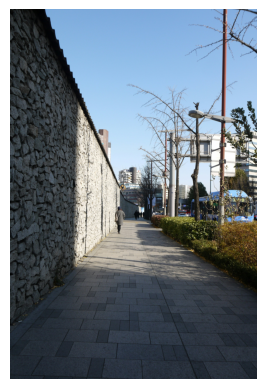

In [18]:
plt.imshow(image)
plt.axis("off")
plt.show()

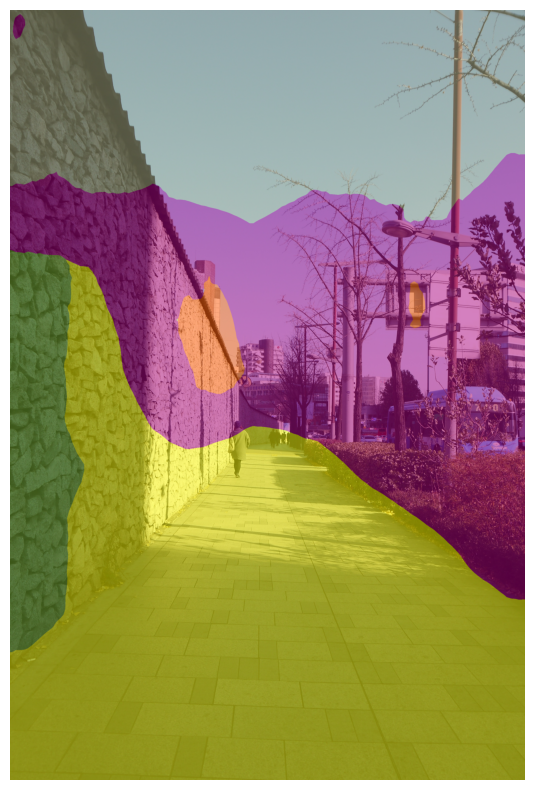

In [19]:
image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in results:
    mask = np.array(result["mask"])
    label = result["label"]

    label_index = list(id2label.values()).index(label)
    color = sidewalk_palette[label_index]
    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis("off")
plt.show()

In [20]:
# evaluate performance test set
metrics = trainer.evaluate(test_ds)
print(metrics)

{'eval_loss': 1.202967643737793, 'eval_mean_iou': 0.1283830627879676, 'eval_mean_accuracy': 0.17519240097260447, 'eval_overall_accuracy': 0.6781591634412983, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_flat-road': 0.6933991979156424, 'eval_accuracy_flat-sidewalk': 0.91927199662213, 'eval_accuracy_flat-crosswalk': 0.0, 'eval_accuracy_flat-cyclinglane': 0.5743461424306984, 'eval_accuracy_flat-parkingdriveway': 0.006818740749794275, 'eval_accuracy_flat-railtrack': nan, 'eval_accuracy_flat-curb': 0.0, 'eval_accuracy_human-person': 0.0, 'eval_accuracy_human-rider': 0.0, 'eval_accuracy_vehicle-car': 0.6072912125720997, 'eval_accuracy_vehicle-truck': 0.0, 'eval_accuracy_vehicle-bus': 0.0, 'eval_accuracy_vehicle-tramtrain': 0.0, 'eval_accuracy_vehicle-motorcycle': 0.0, 'eval_accuracy_vehicle-bicycle': 0.0, 'eval_accuracy_vehicle-caravan': 0.0, 'eval_accuracy_vehicle-cartrailer': 0.0, 'eval_accuracy_construction-building': 0.7586697601860874, 'eval_accuracy_construction-door': 0.0, 'eval_acc